Epoch 1/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 5s 642us/step - accuracy: 0.4528 - loss: 0.8981 - val_accuracy: 0.5920 - val_loss: 0.8174
Epoch 2/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 5s 633us/step - accuracy: 0.6028 - loss: 0.7800 - val_accuracy: 0.6012 - val_loss: 0.8011
Epoch 3/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 5s 676us/step - accuracy: 0.6104 - loss: 0.7612 - val_accuracy: 0.6126 - val_loss: 0.7984
Epoch 4/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 5s 633us/step - accuracy: 0.6149 - loss: 0.7612 - val_accuracy: 0.6113 - val_loss: 0.7925
Epoch 5/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 4s 538us/step - accuracy: 0.6217 - loss: 0.7517 - val_accuracy: 0.6172 - val_loss: 0.7895
Epoch 6/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 4s 524us/step - accuracy: 0.6218 - loss: 0.7831 - val_accuracy: 0.6238 - val_loss: 0.7907
Epoch 7/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 4s 532us/step - accuracy: 0.6241 - loss: 0.7651 - val_accuracy: 0.6223 - val_loss: 0.7895
Epoch 8/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 4s 526us/step - accuracy: 0.6247 -

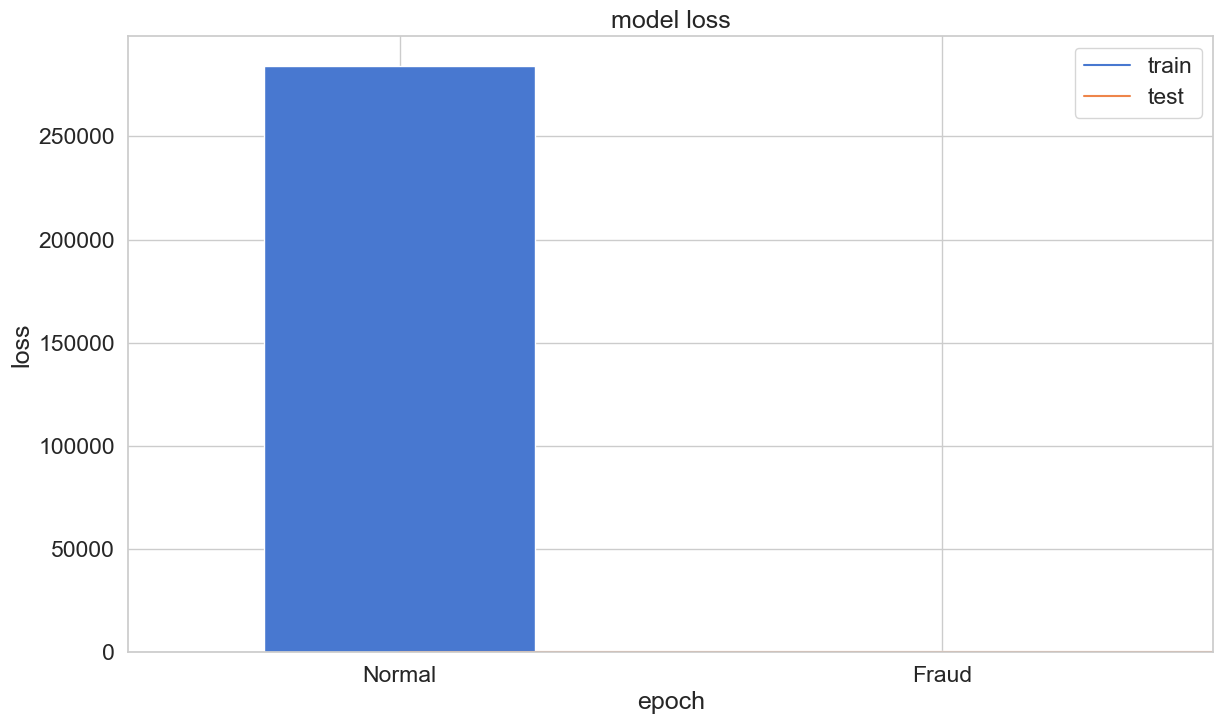

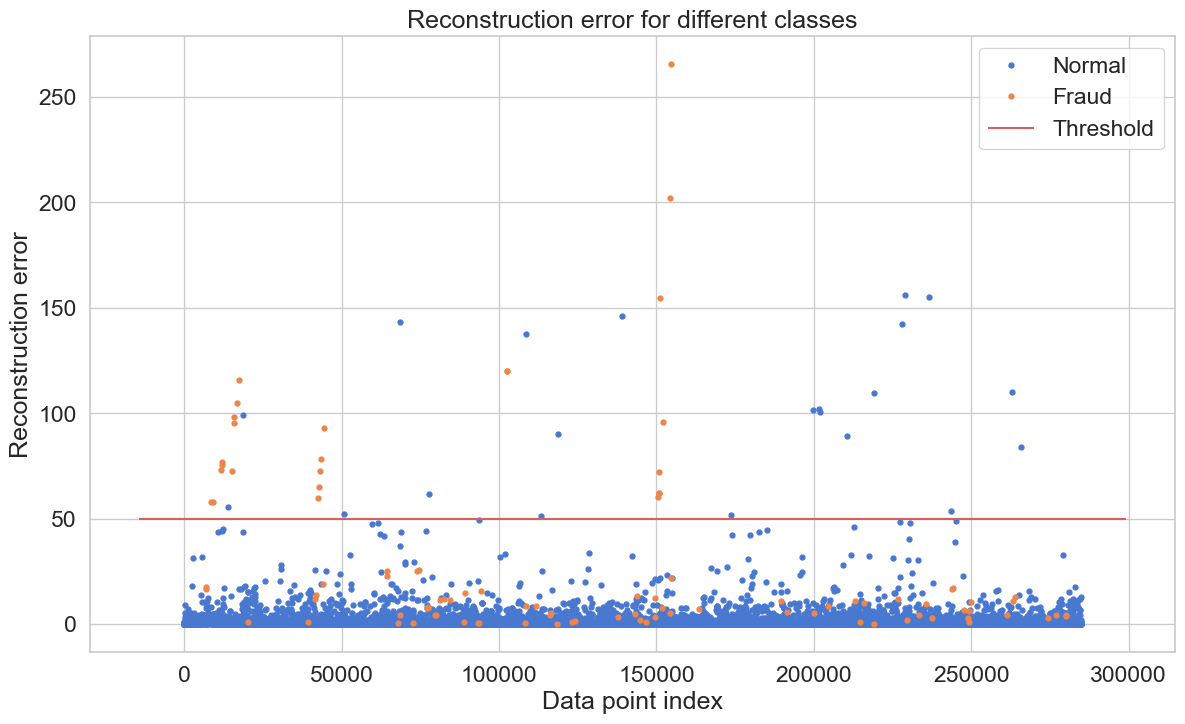

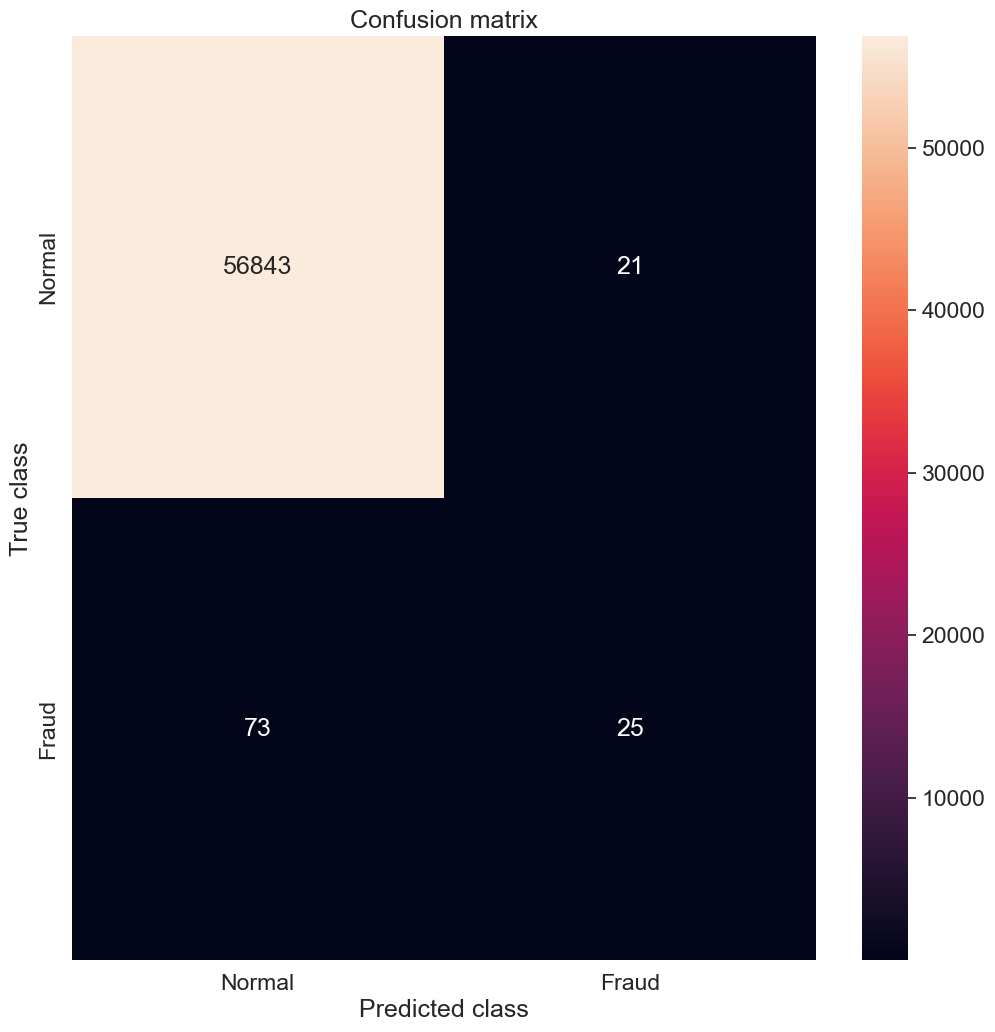

Accuracy: 0.9983497770443454
 Recall: 0.25510204081632654
 Precision: 0.5434782608695652


In [1]:
### Importing libraries

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

df =  pd.read_csv("/Users/harshavardhan/Downloads/creditcard.csv")

### Plotting Bar

count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

### Loading and preparing the data

from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))


X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

input_dim = X_train.shape[1]
encoding_dim = 14

### Encoding and Decoding

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh",
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

nb_epoch = 10
batch_size = 32
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

autoencoder.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['accuracy']
)

# Save the best model with the correct extension
checkpointer = ModelCheckpoint(
    filepath="model.keras",
    verbose=0,
    save_best_only=True
)

tensorboard = TensorBoard(
    log_dir='./logs',
    histogram_freq=0,
    write_graph=True,
    write_images=True
)

history = autoencoder.fit(
    X_train, X_train,
    epochs=nb_epoch,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(X_test, X_test),
    verbose=1,
    callbacks=[checkpointer, early_stop]
).history


plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

predictions = autoencoder.predict(X_test)

### Calculating MSE

mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

error_df.describe()

threshold = 50
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

from sklearn.metrics import confusion_matrix,recall_score,accuracy_score,precision_score

### Confusion matrix

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

error_df['pred'] = y_pred

### Accuracy

# print Accuracy, precision and recall print(" Accuracy:

print("Accuracy:",accuracy_score (error_df['true_class'],error_df['pred']))
print(" Recall:",recall_score(error_df['true_class'],error_df['pred']))
print(" Precision:",precision_score(error_df['true_class'],error_df['pred']))

